# Quantitative research task

This file can also be found on: https://github.com/arvindrajan92/financial-time-series-prediction.

## 1. Data processing

The first task is converting the EOD data into five seperate time series data frames; one each for Open, High, Low, Close and Volume (OHLCV). In each data frame, rows should be indexed by date, and columns by ticker.

First, let's read the data from all the text files.

In [229]:
import glob
import pandas as pd
import numpy as np

# get list of file names from directory
directory = "./ASX-2015-2018/ASX-2015-2018/"
files = glob.glob(directory + '[0-9]*.txt')

# generate list of dataframes from each file (or date) respectively
cl_name = ["ticker", "date", "open", "high", "low", "close", "volume"]
dfs = [pd.read_csv(file, 
                   sep=",", 
                   names = cl_name, 
                   header = None, 
                   parse_dates = ["date"], 
                   index_col = "date") 
       for file in files]

# concatenate the dataframes into one temporary dataframe
df_master = pd.concat(dfs)

Let us first understand how many tickers and observations (days) are there in total based on the concatenated dataframe `df_master`.

In [230]:
# number of tickers in dataframe
print("There are {} tickers with obervations over {} days.".format(df_master.ticker.unique().size, df_master.index.unique().size))

There are 2773 tickers with obervations over 883 days.


Now, let's build dataframe for open, high, low, close, and volume as desired

In [231]:
# using pivot function, for each ticker values, individual dataframes for open, high, low, close, and volume can be built
df_open = df_master[["ticker", "open"]].pivot(columns = "ticker", values = "open")
df_high = df_master[["ticker", "high"]].pivot(columns = "ticker", values = "high")
df_low = df_master[["ticker", "low"]].pivot(columns = "ticker", values = "low")
df_close = df_master[["ticker", "close"]].pivot(columns = "ticker", values = "close")
df_volume = df_master[["ticker", "volume"]].pivot(columns = "ticker", values = "volume")

Below is the close price dataframe (head) for reference.

In [232]:
df_close.head()

ticker,1AD,1AG,1AL,1PG,1ST,3DM,3DP,3PL,4CE,4DS,...,ZNO,ZNT,ZNZ,ZOZI,ZRL,ZTA,ZUSD,ZYB,ZYL,ZYUS
date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,NaN,NaN,NaN,1.215,NaN,NaN,NaN,2.26,NaN,NaN,...,NaN,NaN,NaN,NaN,0.067,NaN,NaN,NaN,NaN,NaN
2015-01-05,NaN,NaN,NaN,1.265,NaN,NaN,NaN,2.07,NaN,NaN,...,NaN,NaN,4.40,NaN,0.070,NaN,NaN,NaN,NaN,NaN
2015-01-06,NaN,NaN,NaN,1.245,NaN,NaN,NaN,2.08,NaN,NaN,...,NaN,NaN,4.39,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-07,NaN,NaN,NaN,1.250,NaN,NaN,NaN,2.05,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.003,NaN,NaN,NaN,NaN
2015-01-08,NaN,NaN,NaN,1.255,NaN,NaN,NaN,2.08,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Next, we create a dataframe containing the future close returns at time $t$, denoted as $r_{t,t+1}$, as defined by:

$$r_{t,t+1}=\frac{P^{c}_{t+1}}{P^{c}_{t}}-1,$$

where $P^c_t$ is the close price at time $t$. This will be the quantity-of-interest that will be predicted.

In [233]:
# to find the future close return of t+1, or the close return of next business day, and assign to the index of t
df_ftr_rtn = (df_close.shift(-1) / df_close) - 1
df_ftr_rtn.head()

ticker,1AD,1AG,1AL,1PG,1ST,3DM,3DP,3PL,4CE,4DS,...,ZNO,ZNT,ZNZ,ZOZI,ZRL,ZTA,ZUSD,ZYB,ZYL,ZYUS
date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,NaN,NaN,NaN,0.041152,NaN,NaN,NaN,-0.084071,NaN,NaN,...,NaN,NaN,NaN,NaN,0.044776,NaN,NaN,NaN,NaN,NaN
2015-01-05,NaN,NaN,NaN,-0.015810,NaN,NaN,NaN,0.004831,NaN,NaN,...,NaN,NaN,-0.002273,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-06,NaN,NaN,NaN,0.004016,NaN,NaN,NaN,-0.014423,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-07,NaN,NaN,NaN,0.004000,NaN,NaN,NaN,0.014634,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-08,NaN,NaN,NaN,0.015936,NaN,NaN,NaN,0.096154,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Also create a data frame containing close returns for the day, which is calculated with respect to the close price of the previous day.

In [234]:
# to find the future close return of t based on t-1 close values and assign to the index of t
df_rtn = (df_close / df_close.shift(1)) - 1
df_rtn.head()

ticker,1AD,1AG,1AL,1PG,1ST,3DM,3DP,3PL,4CE,4DS,...,ZNO,ZNT,ZNZ,ZOZI,ZRL,ZTA,ZUSD,ZYB,ZYL,ZYUS
date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,NaN,NaN,NaN,0.041152,NaN,NaN,NaN,-0.084071,NaN,NaN,...,NaN,NaN,NaN,NaN,0.044776,NaN,NaN,NaN,NaN,NaN
2015-01-06,NaN,NaN,NaN,-0.015810,NaN,NaN,NaN,0.004831,NaN,NaN,...,NaN,NaN,-0.002273,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-07,NaN,NaN,NaN,0.004016,NaN,NaN,NaN,-0.014423,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-08,NaN,NaN,NaN,0.004000,NaN,NaN,NaN,0.014634,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Create a data frame containing the ratios of $\frac{High}{Low}$ for each ticker each day, in the same format.

In [235]:
# dataframe wirh ratio of high/low for each ticker on each day
df_hl = df_high / df_low
df_hl.head()

ticker,1AD,1AG,1AL,1PG,1ST,3DM,3DP,3PL,4CE,4DS,...,ZNO,ZNT,ZNZ,ZOZI,ZRL,ZTA,ZUSD,ZYB,ZYL,ZYUS
date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,NaN,NaN,NaN,1.068966,NaN,NaN,NaN,1.055300,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2015-01-05,NaN,NaN,NaN,1.061224,NaN,NaN,NaN,1.111111,NaN,NaN,...,NaN,NaN,1.022727,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2015-01-06,NaN,NaN,NaN,1.041322,NaN,NaN,NaN,1.039604,NaN,NaN,...,NaN,NaN,1.006865,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-07,NaN,NaN,NaN,1.041667,NaN,NaN,NaN,1.050000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
2015-01-08,NaN,NaN,NaN,1.044534,NaN,NaN,NaN,1.014493,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2. Exploratory data analysis

### 2.1 Hypothesis, motivation, approach and strategy

As of 22 November 2019, based on ASX's website, there are in total 2195 unique tickers currently listed. The dataset however has 2773 unique tickers; which means that it has tickers of companies that have been delisted.

Before analysing the coverage and quality, let us discuss the hypothesis, scope, motivation and strategy of this task.

**Hypothesis**: 
1. Based on research [1-3], the patterns in the technical indicators derived from OHLCV of a particular stock (or company) have the predictive power of its future movements.
2. Additionally, the tehnical indicators of companies contributing to composite indexes, such as ASX All Ordinaries, S&P/ASX 50, etc. can be used to predict the movement of the composite indexes that they belong to.

**Scope**:
This work limits its scope to hypothesis 1.

**Motivation**:
This work extends hypothesis 1 to be more generic: unlike the hypotheses employed in [1-3], the future movement of any stock price can be predicted through the movement and pattern of its technical indicators; and the same prediction from movement and pattern can be applicable to stock price of any company.

Based on studies [1-4], the time series nature of the data recommends the use of long short-term memory (LSTM) paradigm of neural networks, which has been shown to be superior to ensemble methods such as random forest and other classification techniques such as the support vector machines.

**Strategy**:
The strategy here is to build a generic prediction model using the OHLCV data and technical indicators of past 60 (trading) days so as to be able to predict the movement of the stock price of any company. Note that this excludes all composite indexes listed in ASX (as this falls under hypothesis 2).

For this, an LSTM model will be trained using train, validation, and test data to obtain the following metrics: upward or downward movement of the next day stock price. In addition, the random forest classification method will be used for bechmarking and discussion.

### 2.2. Coverage and quality

As it can be observed from the dataframe printed out in the previous section, not all the tickers have complete data. There are 2773 unique tickers and 883 obervations. Now let us first visualise the distribution of number of non-missing values using dataframe `df_close`.

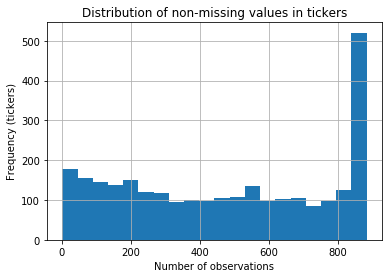

There are 196 tickers with full data available.


In [237]:
import matplotlib.pyplot as plt

# histogram of the number of non-missing values
ax = df_close.notna().sum().hist(bins=20)
plt.xlabel("Number of observations")
plt.ylabel("Frequency (tickers)")
plt.axis("tight")
plt.title("Distribution of non-missing values in tickers")
plt.show()

print("There are {} tickers with full data available.".format(df_close.columns[(df_close.notna().sum() == df_close.shape[0]).values].shape[0])) 

The histogram above shows that there are about 196 tickers with no missing values in close price. For peace of mind, let us alsoe inspect if the `df_master` dataframe is clean.

In [238]:
df_master.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1319997 entries, 2015-01-02 to 2018-06-29
Data columns (total 6 columns):
ticker    1319997 non-null object
open      1319997 non-null float64
high      1319997 non-null float64
low       1319997 non-null float64
close     1319997 non-null float64
volume    1319997 non-null int64
dtypes: float64(4), int64(1), object(1)
memory usage: 70.5+ MB


The result above shows that the master dataframe is indeed clean. This means that all missing values in `df_close` is coming from the price not being registered on the day. After crosschecking with data from the ASX's official website, this is mainly due to the fact that the trade did not take place on that day, company listed after 2015-01-02, or company delisted before 2018-06-29. 

As clean result is of paramount importance, let us disregard the tickers with a lot of missing values and take only the ones with full data from 2015-01-02 to 2018-06-29. In this case, let us consider only the tickers with more than 800 non-missing values.

Secondly, for good predictability, we need companies which have high correlation to the label we intend to predict, which in this case is the future return.

Once the list of tickers that are of interest to us have been shortlisted, we will move on to handling missing data. Also, as mentioned earlier, we are also not interested in the compund indexes as they do not fall within the scope of the approach taken. Therefore, let us remove those tickers as well. After checking with ASX's website, they are the tickers that do not have volume information. Let us now filter the dataframes for tickers that we are interested in.

In [239]:
# Find composite indexes. They can be identified by 0 volume.
non_comp_indexes = df_volume.columns[(df_volume.sum() != 0).values].values

# filter the dataframes
df_open = df_open[non_comp_indexes] # open
df_high = df_high[non_comp_indexes] # high
df_low = df_low[non_comp_indexes] # low
df_close = df_close[non_comp_indexes] # close
df_volume = df_volume[non_comp_indexes] # volume
df_ftr_rtn = df_ftr_rtn[non_comp_indexes] # future return
df_rtn = df_rtn[non_comp_indexes] # return
df_hl = df_hl[non_comp_indexes] # high/low

In [240]:
# get the array of tickers with less more than 800 non-missing values
tickers_good = df_close.columns[(df_close.notna().sum() >= 800).values]

# filter the dataframes
df_open = df_open[tickers_good] # open
df_high = df_high[tickers_good] # high
df_low = df_low[tickers_good] # low
df_close = df_close[tickers_good] # close
df_volume = df_volume[tickers_good] # volume
df_ftr_rtn = df_ftr_rtn[tickers_good] # future return
df_rtn = df_rtn[tickers_good] # return
df_hl = df_hl[tickers_good] # high/low

Now, let us look at the average correlation to future return values and rank the tickers accordingly.

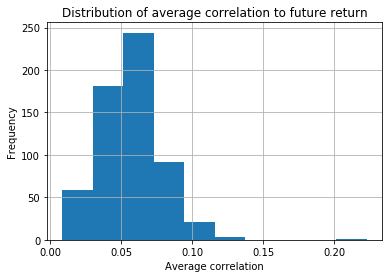

In [241]:
# Let us rank the tickers in ascending order of average correlation
df_corr_score = pd.DataFrame()

# Loops over every ticker
for ticker in tickers_good:
    df = pd.concat([df_open[ticker], 
                    df_high[ticker], 
                    df_low[ticker], 
                    df_close[ticker], 
                    df_volume[ticker], 
                    df_ftr_rtn[ticker], 
                    df_rtn[ticker], 
                    df_hl[ticker]], 
                   axis=1, 
                   keys=["open", "high", "low", "close", "volume", "future_return", "return", "high_low"])
    df_corr_score = df_corr_score.append({"ticker": ticker, 
                                          "avg_corr": df.corr().drop("future_return", axis = 1).loc['future_return'].abs().mean()}, 
                                         ignore_index = True)

# draws the histogram of values of average correlation to future return
df_corr_score.avg_corr.hist();
plt.xlabel("Average correlation")
plt.ylabel("Frequency")
plt.title("Distribution of average correlation to future return")
plt.show()

Based on the histogram above, we can see that there are very few tickers with good correlation to future values. For high profitability, we must take the tickers that possess good predictive power. Let us consider the tickers with average correlation value of more than the 75th percentile.

In [242]:
# get all ticker more than 75th percentile in average correlation
tickers_75 = df_corr_score[df_corr_score.avg_corr > df_corr_score.avg_corr.quantile(0.75)].ticker.values

# filter the dataframes
df_open = df_open[tickers_75] # open
df_high = df_high[tickers_75] # high
df_low = df_low[tickers_75] # low
df_close = df_close[tickers_75] # close
df_volume = df_volume[tickers_75] # volume
df_ftr_rtn = df_ftr_rtn[tickers_75] # future return
df_rtn = df_rtn[tickers_75] # return
df_hl = df_hl[tickers_75] # high/low

Now, let's handle the missing values. There area few ways where the missing values can be handled on the day where the trade did not take place:
1. Volume set to 0 and open, high, low, and close values set to previous day's close value with the assumption that no trade occured on that day for that particular ticker. This approach may introduce outliers in the volume and therefore noise in the data.
2. Interpolate the data OHLCV data using the previous and next available values for smooth transition. Another alternative is to fill in the missing values to be either the mean and median of the column. This, on the other hand, introduces false information and could influence the machine learning model if the number of missing values is large enough.

Let us follow approach 1 as it is theoretically more correct.

In [243]:
# modify original dataframes
df_close = df_close.fillna(method="ffill") # close
df_close = df_close.fillna(method="bfill") # to handle the first row of close
df_volume = df_volume.applymap(lambda x: 0 if pd.isna(x) is True else x) # volume
df_open = df_open.fillna(df_close) # open
df_high = df_high.fillna(df_close) # high
df_low = df_low.fillna(df_close) # low

# calculate other dataframes
df_ftr_rtn = (df_close.shift(-1) / df_close) - 1 # future return
df_rtn = (df_close / df_close.shift(1)) - 1 # return
df_hl = df_high / df_low # high/low

### 2.3. Additional transformations

Before going into performing some visualisations and analysis, let us look at some technical indicators. In essence, we would want to engineer features such that they possess some level of predictive power that could indicate the future direction of the market. Statistically speaking, these features should generally have good correlation to the market movement.

There are numerous such transformations in literature [1-3]. The work by Borovkova et al. [1] consolidates some of the key technical indicators which can be used for additional transformations. Typically, they can be categorised into four groups: (1) Momentum; (2) Trend; (3) Volume; and (4) Volatility. Some of the commonly used indicators are:

    1. Momentum:
        a. Money flow index 
        b. Relative strength index
        c. Stochastic oscillator (%K)
        d. Stochastic oscillator (%D)
        e. William %R
        f. Rate of change
    2. Trend:
        a. Exponential moving average
        b. Moving average convergence-divergence
        c. Commodity channel index
        d. Ichimoku Indicator
    3. Volume:
        a. Accumulation/distribution index
    4. Volatility:
        a. Bollinger bands 
    
Now, let us perform additional transformations. To keep this document succinct, the definition of these indicators-of-interest will be described, whereas information of the other indicators can be obtained from [1-3]. All tranformations will be employing the open-source Python package [5].

#### 2.3.1. Money flow index (MFI)

Money flow index is calculated based on the price and volume to indicate the strength of money in and out from a particular ticker, or in other words, if a particular stock is overbought or oversold. Typically, when MFI of above 80 indicates overbought and oversold when it is below 20.

The MFI can be calculated as follows:

$$\text{MFI} = 100 - \frac{100}{1+\text{MFR}}$$
where
$$\text{MFR} = \frac{\text{Positive Money Flow}}{\text{Negative Money Flow}}$$

$$\text{Money Flow} = \left(\frac{\text{High} + \text{Low} + \text{Close}}{3}\right)\text{Volume}$$

and MFR denotes money flow ratio.

In [244]:
import ta # import package

# mfi dataframe
df_mfi = pd.DataFrame()

# loop over all tickers
for ticker in df_close.columns:
    # calculate mfi
    temp = ta.momentum.money_flow_index(high=df_high[ticker], 
                                        low=df_low[ticker], 
                                        close=df_close[ticker], 
                                        volume=df_volume[ticker],
                                        fillna=True)
    # concatenate with main dataframe
    df_mfi = pd.concat([df_mfi, temp], axis=1)

# rename the columns
df_mfi.columns = df_close.columns

#### 2.3.2. Exponential moving average (EMA)

The exponential moving average is exponentially weighed moving average calculated by exponentially decreasing the weight of observations $x_i$ with respect to their distance from $x_t$ using weighted multiplier $\alpha$. For example, $\alpha = 0.1$ gets only 10% of the current value into EMA. Since only a small portion of the current value is taken, most of the old values are preserved. Essentially, EMA is defined as:

$$\text{EMA}(x_t, \alpha) = \alpha x_t + (1 − \alpha) \text{EMA}(x_{t−1}, \alpha).$$

and

$$\alpha = \frac{2}{N+1}$$

where $N$ is number of days in a period. In this study, let us use $N = 10$ to be consistent with MFI, and hence $\alpha = 0.13333$ using the close price of day $t$ as $x_t$.

In [245]:
# ema dataframe
df_ema = df_close.apply(ta.trend.ema_indicator, fillna=True)

#### 2.3.3. Relative strength index (RSI)

Just like the MFI, the relative strength index is another momentum indicator, but uses the velocity and magnitude of price momevents and also to indicate whether a stock is overbought or oversold. The RSI can be simply calculated as follows:

$$\text{RSI} = 100 - \frac{100}{1+\text{RS}}$$

where

$$\text{RS} = \frac{\text{Average of up closes}}{\text{Average of down closes}}$$

is the relative strength. For consistency, let us use $N = 10$ when calculating the average.

In [246]:
# rsi dataframe
df_rsi = df_close.apply(ta.momentum.rsi, fillna=True)

#### 2.3.4. Stochastic oscillator (SO)

The stochastic oscillator (or Stochastic %K) is a momentum indicator calculated using the highest high price over a period of time $N$, lowest low price over a period of time $N$, and the current close price. The calculation can be simply performed as:

$$\text{%K} = \left(\frac{\text{Close} - \text{Lowest Low}}{\text{Highest High} - \text{Lowest Low}} \right)*100$$

which gives the result in percentage.

The fast stochastic indicator (Stochastic %D) is normally the 3-period moving average of %K. Both indicators will be calculated below.

In [247]:
# stoch_k and stoch_d dataframe
df_stoch_k = pd.DataFrame()
df_stoch_d = pd.DataFrame()

# loop over all tickers
for ticker in df_close.columns:
    # calculate %k
    temp = ta.momentum.stoch(high=df_high[ticker],
                             low=df_low[ticker],
                             close=df_close[ticker],
                             fillna=True)
    # concatenate with main dataframe
    df_stoch_k = pd.concat([df_stoch_k, temp], axis=1)
    
    # calculate %d
    temp = ta.momentum.stoch_signal(high=df_high[ticker],
                                   low=df_low[ticker],
                                   close=df_close[ticker],
                                   fillna=True)
    # concatenate with main dataframe
    df_stoch_d = pd.concat([df_stoch_d, temp], axis=1)

# rename the columns
df_stoch_k.columns = df_close.columns
df_stoch_d.columns = df_close.columns

#### 2.3.5. Moving average convergence-divergence (MACD)

The moving average convergence-divergence is an indicator that shows the relationship between 12-period EMA and 26-period EMA. This index can be used to measure the trend-following momentum of a security. Accordingly, it is calculated as:

$$\text{MACD} = \text{12-Period EMA} - \text{26-Period EMA}$$

where EMA is the exponential moving average, as defined and programmed earlier.

In [248]:
# macd dataframe
df_macd = df_close.apply(ta.trend.macd_diff, fillna=True)

#### 2.3.6. William %R

William's %R is another momentum indicator that ranges between -100 and 0 which shows the overbought and oversold of a stock price. For example, a reading above -20 is overbought and a reading below -80 is oversold. Typically, it is calculated over the period of last $N=14$ days.

This indicator can be simply calculated as follows:

$$\text{%R} = \frac{\text{Highest High} - \text{Close}}{\text{Highest High} - \text{Lowest Low}}$$

In [249]:
# william_r dataframe
df_will_r = pd.DataFrame()

# loop over all tickers
for ticker in df_close.columns:
    # calculate william_r
    temp = ta.momentum.wr(high=df_high[ticker],
                          low=df_low[ticker],
                          close=df_close[ticker],
                          fillna=True)
    # concatenate with main dataframe
    df_will_r = pd.concat([df_will_r, temp], axis=1)

# rename the columns
df_will_r.columns = df_close.columns

#### 2.3.7. Commodity channel index (CCI)

The commodity channel index is another trend indicator, but the difference in this indicator is that it measures the difference between the current price and the historical average price. This indicator can be calculated as follows:

$$\text{CCI}=\frac{1}{0.015}\frac{\text{Typical Price}-\text{SMA}\left( \text{Typical Price}\right)}{\text{MD}\left( \text{Typical Price}\right)}$$

where $\text{SMA}$ is the simple moving average and $\text{MD}$ is the mead absolute deviation.

When the CCI is above zero it indicates the price is above the historic average. When CCI is below zero, the price is below the historic average. Readings above 100 typically signals buy signal; and sell signal for reading below -100.

In [250]:
# cci dataframe
df_cci = pd.DataFrame()

# loop over all tickers
for ticker in df_close.columns:
    # calculate cci
    temp = ta.trend.cci(high=df_high[ticker],
                        low=df_low[ticker],
                        close=df_close[ticker],
                        fillna=True)
    # concatenate with main dataframe
    df_cci = pd.concat([df_cci, temp], axis=1)

# rename the columns
df_cci.columns = df_close.columns

#### 2.3.8. Ichimoku indicator

The Ichimoku Cloud is a collection of technical indicators that show support and resistance levels, as well as momentum and trend direction. To keep the indicators simple, only the two important indicators from Ichimoku Cloud are used: leading spans A and B. More information on the Ichimoku indicator can be found through online sources and literature.

In [251]:
# ichi_a and ichi_b dataframe
df_ichi_a = pd.DataFrame()
df_ichi_b = pd.DataFrame()

# loop over all tickers
for ticker in df_close.columns:
    # calculate ichi_a
    temp = ta.trend.ichimoku_a(high=df_high[ticker],
                               low=df_low[ticker],
                              fillna=True)
    # concatenate with main dataframe
    df_ichi_a = pd.concat([df_ichi_a, temp], axis=1)
    
    # calculate ichi_b
    temp = ta.trend.ichimoku_b(high=df_high[ticker],
                               low=df_low[ticker],
                              fillna=True)
    # concatenate with main dataframe
    df_ichi_b = pd.concat([df_ichi_b, temp], axis=1)

# rename the columns
df_ichi_a.columns = df_close.columns
df_ichi_b.columns = df_close.columns

#### 2.3.9. Accumulation/distribution index

Accumulation/distribution is a cummulative indicator that makes use of volume and price to determine if the stock is being accummulated of distributed. Typically, a rising A/D line helps confirm a rising price trend whereas a falling A/D line helps confirm a price downtrend.

$$\text{A/D} = \text{Previous A/D} + { (\text{Close} - \text{Low}) - (\text{High} - \text{Close}) \over \text{High} - \text{Low} }*\text{Volume}$$

In [252]:
# A/D dataframe
df_ad = pd.DataFrame()

# loop over all tickers
for ticker in df_close.columns:
    # calculate cci
    temp = ta.volume.acc_dist_index(high=df_high[ticker],
                                    low=df_low[ticker],
                                    close=df_close[ticker],
                                    volume=df_volume[ticker],
                                    fillna=True
                                   )
    # concatenate with main dataframe
    df_ad = pd.concat([df_ad, temp], axis=1)

# rename the columns
df_ad.columns = df_close.columns

#### 2.3.10. Bollinger bands

Bollinger bands are two lines that are two standard deviations away from the EMA. It is a volatility indicator. Here, it will be presented in terms of percentage as:

$$\text{BB} = \frac{\text{Close}-\text{Lower Band}}{\text{Higher Band} - \text{Lower Band}}$$

Typically, value of above 0.8 gives sell signal; and buy signal for value below 0.2.

In [253]:
# Calculate upper and lower band
df_bb_up = df_close.apply(ta.volatility.bollinger_hband, fillna=True)
df_bb_down = df_close.apply(ta.volatility.bollinger_lband, fillna=True)

### 2.4. Data analysis

Before performing some data analysis, let us first arrange all dataframes in an array. Further, let's define the training, validation, and testing sets as follows:

1. datetime range: 2015-01-02 to 2018-06-29
    - train: 2015-02-01 to 2017-06-30
    - evaluation: 2017-07-01 to 2017-12-31
    - test: 2018-01-01 to 2018-06-29

In [254]:
# list all the dataframes of interest
dfois = [df_open, df_high, df_low, df_close,df_volume, df_rtn, df_hl,
         df_mfi, df_ema, df_rsi, df_stoch_k, df_stoch_d, df_macd, df_will_r, df_cci,
         df_ichi_a, df_ichi_b, df_ad, df_bb_up, df_bb_down, df_ftr_rtn]
dfois_str = ['open', 'high', 'low', 'close', 'volume', 'rtn', 'hl','mfi', 'ema', 'rsi', 'stoch_k', 'stoch_d', 'macd', 
             'will_r', 'cci', 'ichi_a', 'ichi_b', 'ad', 'bb_up', 'bb_down', 'ftr_rtn']

# remove dates prior to 2015-02-01 and the date 2018-06-29
[df.drop(df.iloc[df.index < '2015-02-01'].index, inplace=True) for df in dfois];
[df.drop(df.iloc[df.index == '2018-06-29'].index, inplace=True) for df in dfois];

First, let us find the correlation between all the dataframes, or in other words, between features. Because we have numerous tickers in a dataframe, it could be difficult to visualise the correlation matrix for all tickers. Therefore, here, we take the average correlation value and visualise the correlations using a heatmap.

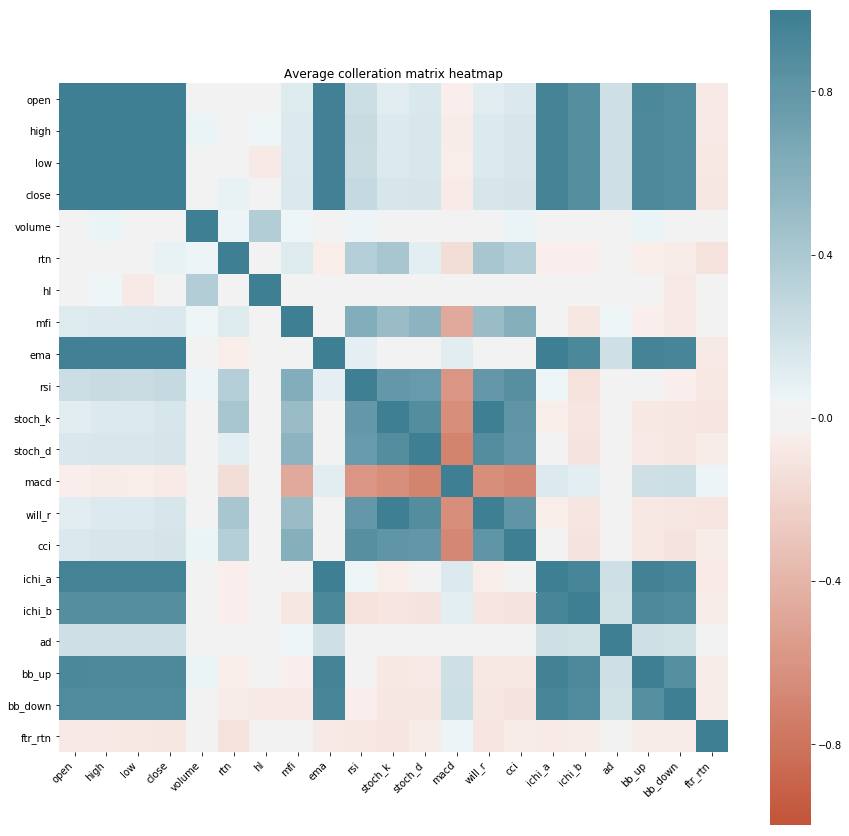

In [257]:
import seaborn as sns

# initialise numpy array
corr_val = np.empty([len(dfois),len(dfois)])

# loop over every dataframe and find correlation
for i, df1 in enumerate(dfois):
    for j, df2 in enumerate(dfois):
        corr_val[i][j] = df1.corrwith(df2).mean()
    
# visualise the correlation matrix using seaborn
fig, ax = plt.subplots(figsize=(15,15))
df_corr = pd.DataFrame(corr_val, columns=dfois_str, index=dfois_str)

# draw heatmap using seaborn - better visualisation
sns.heatmap(
    df_corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=500),
    square=True,
    ax=ax)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right');

ax.set_title('Average colleration matrix heatmap');

In additian to the correlation matrix heatmap, let us also have a look at the histogram of data to look for outliers. Before we do that, we need to normalise the data from 0 to 1 for every ticker so that they can be visualised and benchmarked appropriately.

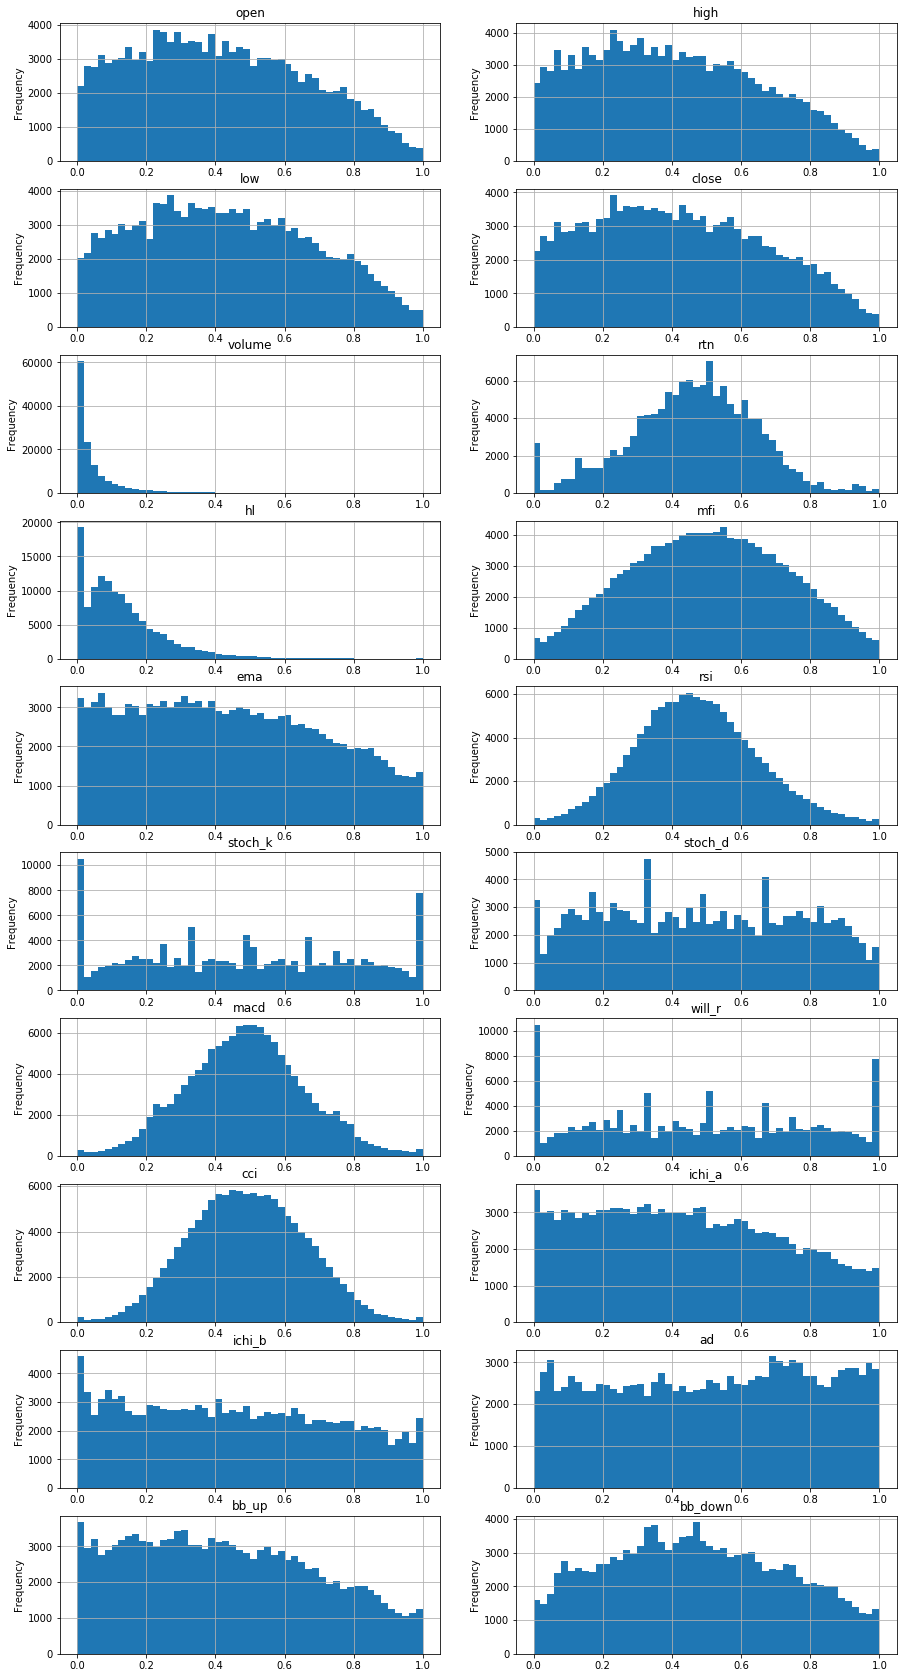

In [258]:
from sklearn import preprocessing

# normalise and draw subplots for each feature
fig, axs = plt.subplots(10,2, figsize=(15, 30))   
for i, ax in enumerate(axs.flatten()):
    if i >= 20:
        pass
    else:
        nomaliser = preprocessing.MinMaxScaler(feature_range=(0,1))
        df_val = nomaliser.fit_transform(dfois[i])
        ax.hist(df_val.reshape(df_val.shape[0]*df_val.shape[1]), bins=50)
        ax.set_title(dfois_str[i])
        ax.set_ylabel('Frequency')
        ax.grid()

Now, let us analyse the correlation heatmap and histograms above.
- Firstly, open, high, low and close values are highly correlated to each other. This is expected because the values are within close proximity to each other. As the technical indicators are calculated using these values and intrinsicly retain its information, open, high, and low values can be removed from feature list.
- Most of the distributions above are either normal or uniform in shape, expect for hl and volume. This suggests that there will be a large number of outliers in those two features. Although the other features with normal distribution may have outliers in the tail section, they can be considered negligible. In addition, observing the correlation matrix, they also appear to have low correlation to future return, which is the metric we will be predicting. Therefore, it justifies to leave hl and volume out from the feature list.
- Similarly, based on the correlation matrix heatmap, some values appear to not have much correlation to ftr_rtn. They are: mfi and ad. To keep the prediction model simple, these features can also be regarded as not useful.
- Finally, it also appears that stoch_k is highly correlated to william_r. This is expected because the mathematical expression of both the indicators are similar. Here, william_r will be removed from the feature list.

Based on the discussion above, the final feature list would be: close, rtn, ema, rsi, stoch_k, stoch_d, macd, cci, ichi_a, ichi_b, bb_up, bb_down.

Our strategy is to predict the UP and DOWN movement of a stock together. Based on experience, this is a better strategy compared to predicting the direction of future return as the performance metric based on this can be misleading. For example, if we build a model that minimises the mean-squared-error, that still doesn't mean that the direction of the movement can be correct. If the actual movement is 0.1%, then investing based on 0.5% is better compared to -0.1% prediction although the later might have a error value.

Now, we first need to create a target dataframe that categorises into 1 and 0: 1 for UP and 0 for DOWN. Then, let us look at the distribution of the values.

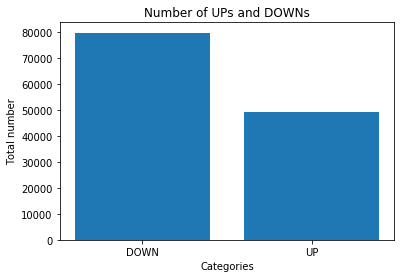

In [259]:
# Create target dataframe
df_target = (df_ftr_rtn > 0).astype(int)

# Look at the proportion
values, counts = np.unique(df_target.values.reshape(df_target.shape[0]*df_target.shape[1]), return_counts=True)
plt.bar(values,counts,tick_label=['DOWN','UP'])
plt.title('Number of UPs and DOWNs')
plt.ylabel('Total number')
plt.xlabel('Categories')
plt.show()

Based on the analysis above, it appears that there are more DOWNs than UPs. Therefore, some balancing is required before sending the data for machine learning. Before going into forecasting section, the final list of dataframes should be defined based on the features list finalised earlier.

In [260]:
# list all the dataframes of interest
dfois = [df_close, df_rtn, df_ema, df_rsi, df_stoch_k, df_stoch_d, df_macd, df_cci,
         df_ichi_a, df_ichi_b, df_bb_up, df_bb_down, df_target]
dfois_str = ['close', 'rtn', 'ema', 'rsi', 'stoch_k', 'stoch_d', 'macd', 'cci',
         'ichi_a', 'ichi_b', 'bb_up', 'bb_down', 'target']

## 3. Forecasting

### 3.1. Long short-term memory model

#### 3.1.1. Preprocessing

Based on the EDA done in the previous section, this section builds an LSTM neural network model for the prediction of the next day stock price moment; whether it is going upward or downward. 

First, let us preprocess the data. Let us normalise all the data to be between 0 and 1. Note that the maximum and minimum is with respect to each ticker in each dataframe.

In [261]:
# list of normalisers corresponding to each dataframe
nomalisers = []

for i, df in enumerate(dfois[:-1]):
    nomalisers.append(preprocessing.MinMaxScaler(feature_range=(0,1)))
    columns = df.columns
    index = df.index
    df = nomalisers[i].fit_transform(df)
    dfois[i] = pd.DataFrame(df, columns=columns, index=index)

Next, let's split the data to training, validation, and test sets. The training and validation sets will be using during the LSTM network training, while the test set will be used for trading strategy implementation and additional testing of the final model.

In [33]:
# split all dataframes into test, training, and evaluation sets
# train set
dfois_train = []
for df in dfois:
    dfois_train.append(df.iloc[df.index < '2017-07-01'])

# test set
dfois_test = []
for df in dfois:
    dfois_test.append(df.iloc[df.index >= '2018-01-01'])

# validation set
dfois_eval = []
for df in dfois:
    dfois_eval.append(df.iloc[(df.index >= '2017-07-01') & (df.index < '2018-01-01')])

Now, let us scale the data to have mean 0 and unit variance. This scaling is done by training the scaler using data of entire normalised training dataframe. This will be used to transform the training, validation, and test sets.

In [262]:
# list of scalers corresponding to each dataframe
scalers = []

# standardise the data by fitting the train set
for i, _ in enumerate(dfois[:-1]):
    # create the Scaler object
    scalers.append(preprocessing.StandardScaler())
    
    # columns and indexes
    columns = dfois_train[i].columns
    index_train = dfois_train[i].index
    index_test = dfois_test[i].index
    index_eval = dfois_eval[i].index
    
    # fit scale
    flat_arr = dfois_train[i].values.reshape(dfois_train[i].shape[0]*dfois_train[i].shape[1],1)
    scalers[i].fit(np.tile(flat_arr, dfois_train[i].shape[1]))
    
    # trasform
    train_data = scalers[i].transform(dfois_train[i])
    eval_data = scalers[i].transform(dfois_eval[i])
    test_data = scalers[i].transform(dfois_test[i])
    
    # replace list
    dfois_train[i] = pd.DataFrame(train_data, columns=columns, index=index_train)
    dfois_eval[i] = pd.DataFrame(eval_data, columns=columns, index=index_eval)
    dfois_test[i] = pd.DataFrame(test_data, columns=columns, index=index_test)

Now, let us sequence the data. As we are using the past 60 days of data for the next day prediction, we need to append the past 60 days worth data and append them in an array. We first write a function and execute onto all three sets of data.

In [269]:
# arrange sequential_data
from collections import deque
import random

# look at the past 60 days
SEQ_LEN = 60

def sequence_data(df_list, shuffle=True):
    # list containing the data
    sequential_data = []

    for ticker in df_close.columns:
        # initialise dataframe
        df_ticker = pd.DataFrame()

        # concatenate the dataframes
        for df in df_list:
            df_ticker = pd.concat([df_ticker, df[ticker]], axis=1)

        prev_days = deque(maxlen=SEQ_LEN)
        # for values in every row
        for i in df_ticker.values: 
            # remove the targets
            prev_days.append([n for n in i[:-1]])  
            # append when sequence length is reached
            if len(prev_days) == SEQ_LEN: 
                sequential_data.append([np.array(prev_days), i[-1]])
                
        # shuffle - we do not need to do this for test set
        if shuffle == True:
            random.shuffle(sequential_data)

    return sequential_data

In [263]:
# sequence all data sets
sequential_data_train = sequence_data(dfois_train)
sequential_data_eval = sequence_data(dfois_eval)
sequential_data_test = sequence_data(dfois_test, shuffle=False) # do not shuffle just this one

# print the length
print('Training data length: {}'.format(len(sequential_data_train)))
print('Validation data length: {}'.format(len(sequential_data_eval)))
print('Testing data length: {}'.format(len(sequential_data_test)))

Training data length: 82800
Validation data length: 10350
Testing data length: 9600


Once sequencing is complete, we need to balance the data. This is to make sure the LSTM model is not biased towards the downward trends, as observed earlier during data analysis. Let us prepare a function for that, and go on to separate sequences into X (features) and y (target).

In [264]:
# balance train and evaluation data
def balance_data(sequential_data):
    ups = [] 
    downs = [] 
    
    # separate the sequence into ups and downs
    for seq, target in sequential_data:
        if target == 0:
            downs.append([seq, target])
        elif target == 1:
            ups.append([seq, target])
    
    # shuffle to randomise
    random.shuffle(ups)
    random.shuffle(downs)
    
    # get the shorter length
    lower = min(len(ups), len(downs))
    
    # truncate the list to shorter length
    ups = ups[:lower]
    downs = downs[:lower]
    
    # merge and shuffle
    sequential_data = ups+downs
    random.shuffle(sequential_data)
    
    return sequential_data

In [265]:
# separate train and target data
def separate_data(sequential_data):
    X = []
    y = []
    
    # loop over every row in sequential data
    for seq, target in sequential_data:
        X.append(seq)
        y.append(target)

    return np.array(X), y

In [266]:
# perform balancing by calling the function
train_x, train_y = separate_data(balance_data(sequential_data_train))
validation_x, validation_y = separate_data(balance_data(sequential_data_eval))

#### 3.1.2. Building and training the LSTM model

Now, let us build the LSTM models using batch size of 64 and run it for 40 epochs. The summary of the model will be printed out. 

Essentially, the LSTM models will have 3 LSTM layers and dense layer with activation and then finally a dense output layer with softmax activation function as this is a classification problem. The softmax activation function will output the probability of the classification.

To avoid overfitting, dropout layers with are added. As additional measure, regularisation could also be added if deemed necessary so that the weights optimised during training do not get too large. However, in this case, they are not necessary.

A adaptive first-order gradient-based optimization known as Adam is used for optimising the network. Another famous optimiser would be the stochastic gradient descent known as SGD. As this is a classification problem, accuracy calculated using sparse categorical crossentropy and loss functions are used as the performance metric.

All the metrics specified above are hyperparameters for this model. A hyperparameter search using a grid of batch size, epochs, unit values and optimisers can be performed, but due to the hardware limitations of my laptop, I will stick with the initial hyperparameters I have chosen based on literature review and intuition from past experience.

In [267]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint, ModelCheckpoint

# batch size and epochs
BATCH_SIZE = 64
EPOCHS = 40

# build LSTM prediction model
model = Sequential()

model.add(LSTM(128, input_shape=(train_x.shape[1:]), activation='tanh', return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(LSTM(128, activation='tanh', return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(LSTM(128, activation='tanh'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(2, activation='softmax'))

# Compile model
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(lr=0.001, decay=1e-6),
              metrics=['accuracy'])

# Model summary
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 60, 128)           72192     
_________________________________________________________________
dropout_8 (Dropout)          (None, 60, 128)           0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 60, 128)           512       
_________________________________________________________________
lstm_7 (LSTM)                (None, 60, 128)           131584    
_________________________________________________________________
dropout_9 (Dropout)          (None, 60, 128)           0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 60, 128)           512       
_________________________________________________________________
lstm_8 (LSTM)                (None, 128)               131584    
__________

We now train the model and store the model as `model.h5` in case I need to reload the model.

In [345]:
# Train model
history = model.fit(train_x, train_y,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(validation_x, validation_y))

Train on 63302 samples, validate on 8232 samples
Epoch 1/40
63302/63302 [==============================] - 982s 16ms/step - loss: 0.7080 - acc: 0.5175 - val_loss: 0.6941 - val_acc: 0.5306
Epoch 2/40
63302/63302 [==============================] - 873s 14ms/step - loss: 0.6925 - acc: 0.5212 - val_loss: 0.6918 - val_acc: 0.5172
Epoch 3/40
63302/63302 [==============================] - 880s 14ms/step - loss: 0.6911 - acc: 0.5283 - val_loss: 0.6910 - val_acc: 0.5135
Epoch 4/40
63302/63302 [==============================] - 878s 14ms/step - loss: 0.6890 - acc: 0.5379 - val_loss: 0.6822 - val_acc: 0.5674
Epoch 5/40
63302/63302 [==============================] - 882s 14ms/step - loss: 0.6864 - acc: 0.5480 - val_loss: 0.6839 - val_acc: 0.5578
Epoch 6/40
63302/63302 [==============================] - 880s 14ms/step - loss: 0.6846 - acc: 0.5557 - val_loss: 0.6831 - val_acc: 0.5566
Epoch 7/40
63302/63302 [==============================] - 882s 14ms/step - loss: 0.6836 - acc: 0.5591 - val_loss: 0.6

In [347]:
# save the model
model.save("model.h5")

In [271]:
# load the model
model = load_model("model.h5")

#### 3.1.3. Analysing model performance

Let us look at the history of loss function that is optimised. From the graph below, we can see that the loss function from training and validation data are being minimised and they are within close proximity to each other. This shows that the model is not over- or under-fit.

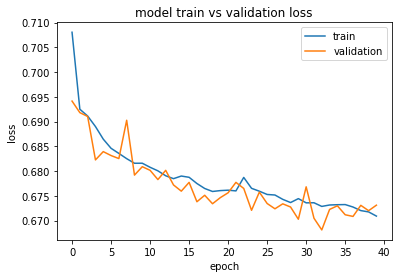

In [348]:
# plot the loss function
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

Now let us look at the accuracy based on the test dataset as well as the classification report based on the 2018 data which the model has never seen during training.

In [273]:
from sklearn.metrics import classification_report

# test performance using test set
test_x, test_y = separate_data(sequential_data_test)

# get the prediction
pred = model.predict_classes(test_x)

# get prediction probability
pred_proba = model.predict(test_x)

# accuracy using test
score = model.evaluate(test_x, test_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('')

# classification report
print('Classification report:')
print(classification_report(test_y, pred))

Test loss: 0.678178130487601
Test accuracy: 0.5464583333333334

Classification report:
             precision    recall  f1-score   support

        0.0       0.74      0.43      0.54      6038
        1.0       0.44      0.75      0.55      3562

avg / total       0.63      0.55      0.55      9600



The accuracy score based on the test set shows that the results are in line with research [4] whereby the accuracy on test set is lower than that of the training and validation set. The prediction of upward movement has low precision compared to that of the downward trend, which means that there are more false positives when predicting the upward movement. Often, the recall score is inversely proportional to the precision. Therefore, the best measure is the f1-score, which is acceptable for developing a trading strategy.

#### 3.1.4. Trading strategy

Let us define a simple trading strategy. Of all 150 tickers used, open position using \$1 for each ticker based on the predicted movement by the LSTM network, and close position the next day. This means that everyday, an investment of \$150 is made and position must be closed the next day.

Note that, as the LSTM network requires 60 days of past data, the trading is simulated from 2018-03-27. The cumulative profit and loss (PnL) will be plotted.

In [274]:
# build index list
pred_index = dfois_test[0].index[dfois_test[0].index >= dfois_test[0].head(60).index[-1]]

# build prediction dataframe - 1 is BUY and 0 is SELL
df_pred = pd.DataFrame(pred.reshape(dfois_test[0].shape[0]-SEQ_LEN+1,dfois_test[0].shape[1], order='F'),
                       index = pred_index,
                       columns = dfois_test[0].columns)

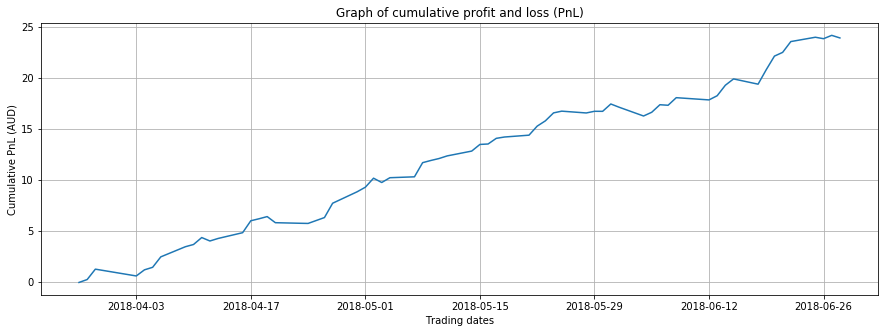

In [276]:
# dataframe for right prediction - 1 is CORRECT and 0 is WRONG
df_right = (df_pred.astype(bool) == df_target.loc[pred_index].astype(bool)).astype(int)

# dataframe for wrong prediction - 1 is WRONG and 0 is CORRECT
df_wrong = (~df_right.astype(bool)).astype(int)

# datframe for profit
df_profit = df_right*df_ftr_rtn.loc[pred_index].abs()

# dataframe for loss
df_loss = df_wrong*df_ftr_rtn.loc[pred_index].abs()

plt.subplots(figsize=(15,5))
plt.plot((df_profit.sum(axis=1) - df_loss.sum(axis=1)).cumsum())
plt.grid()
plt.xlabel('Trading dates')
plt.ylabel('Cumulative PnL (AUD)')
plt.title('Graph of cumulative profit and loss (PnL)')
plt.show()

Following the simple strategy, based on 64 days of trading and \$150 investment per day, the total profit made is about \$24. On average, this is a 0.25% daily return on investment (ROI). Considering the numbers and the linear trend of the cumulative PnL, I would say that this is a ***successful strategy***. 

### 3.2. Random forest model

#### 3.2.1. Preprocessing

Unlike the LSTM, the format of data required for the random forest, as for most of other machine learning models, is straight forward. Let us first transform the data into a unified dataframe, similar to `df_main`.

In [280]:
# initialise dataframe
df_master_std = pd.DataFrame()

# loop over every dataframe of interest for train and evaluation
for i, df in enumerate(dfois_train):    
    # temporary dataframe
    df_temp = pd.concat([dfois_train[i],dfois_eval[i],dfois_test[i]])
    df_temp.reset_index(inplace=True)
    df_temp = df_temp.melt(id_vars='date', var_name='ticker', value_name=dfois_str[i])
    df_temp.date = pd.to_datetime(df_temp.date)
    
    # set the index
    df_temp.set_index(['date'], inplace=True)
    
    # concatenate on index
    df_master_std = pd.concat([df_master_std,df_temp], axis=1).drop('ticker', axis=1)

# add future return into the dataframe
df_temp = df_ftr_rtn.copy()
df_temp.reset_index(inplace=True)
df_temp = df_temp.melt(id_vars='date', var_name='ticker', value_name='ftr_rtn')
df_temp.date = pd.to_datetime(df_temp.date)
df_temp.set_index(['date'], inplace=True)
df_master_std = pd.concat([df_master_std,df_temp], axis=1, join='inner').drop('ticker', axis=1)

Let us now split the dataset to training and test. All training sets are before 2018-01-01 and test datasets are from 2018-01-01, just like we did for LSTM. To keep it simple, cross validation is not performed here. Note that as this is time series data, cross validation has to be performed using the TimeSeriesSplit class from scikit learn in order to prevent look-ahead bias.

In [282]:
# train and validation datasets
df_rf_train = df_master_std.iloc[df_master_std.index < '2018-01-01']
df_rf_test = df_master_std.iloc[df_master_std.index >= '2018-01-01']

In [290]:
# split dataset into training set and test set
feat_list = dfois_str[:-1]
targ_list = dfois_str[-1]

# finalise X and y values
X = np.array(df_rf_train[feat_list])
y = np.array(df_rf_train[targ_list])

# reshape the labels
y = np.reshape(y, (y.shape[0],))

In [295]:
from sklearn.model_selection import train_test_split

# randomise the training data
X_train, _, y_train, _ = train_test_split(X, y, test_size=0.0, random_state=42) 

#### 3.2.2. Building and training the random forest model

The random forest model is built here using 100 trees. Again, as this parameter along with more parameters can be tuned using gridsearch, this is not prioritised here.

In [296]:
# import the random forest class
from sklearn.ensemble import RandomForestClassifier

# create rf classifier model
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

#### 3.2.3. Analysing model performance

Let us look at the test accuracy and classification report generated using the test data.

In [298]:
# accuracy using test
print("Test accuracy:", clf.score(df_rf_test.loc[:,feat_list], df_rf_test.loc[:,targ_list]))
print('')

# classification report
print('Classification report:')
print(classification_report(df_rf_test.loc[:,targ_list], clf.predict(df_rf_test.loc[:,feat_list])))

Test accuracy: 0.6197831978319783

Classification report:
             precision    recall  f1-score   support

          0       0.65      0.85      0.74     11628
          1       0.47      0.23      0.31      6822

avg / total       0.59      0.62      0.58     18450



Similar to the LSTM model, the precision of upward movement prediction is significantly lower than that of the the downward movement. The accuracy and f1-score is higher is notably higher than those of the LSTM. 

#### 3.2.4. Trading strategy

Let us follow the same strategy that was employed for the LSTM method and overlay the PnL graph.

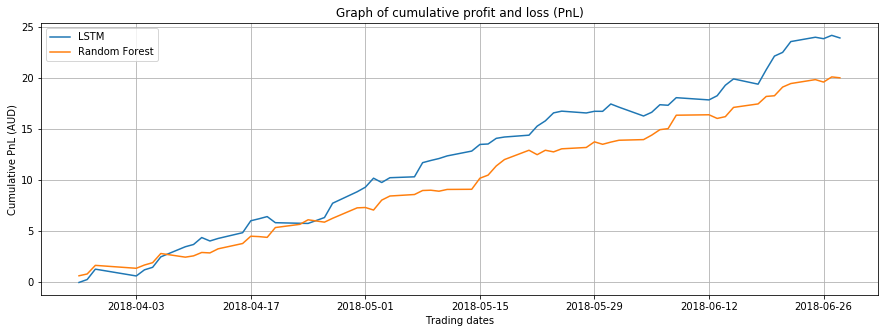

In [310]:
# add predict and pnl column for random forest
df_rf_test["predict_RF"] = clf.predict(np.array(df_rf_test.loc[:,feat_list]));
df_rf_test["PnL_RF"] = ((df_rf_test["target"] == df_rf_test["predict_RF"]).astype(int)-0.5)*2*df_rf_test["ftr_rtn"].abs();

# get the pnl values from the starting date in LSTM
pnl = df_rf_test.groupby(['date'])['PnL_RF'].sum()
pnl = pnl.iloc[pnl.index >= '2018-03-27']

# plot the figure
plt.subplots(figsize=(15, 5))
plt.plot((df_profit.sum(axis=1) - df_loss.sum(axis=1)).cumsum(), label = "LSTM")
plt.plot(pnl.index, pnl.cumsum(), label = "Random Forest")
plt.xlabel('Trading dates')
plt.ylabel('Cumulative PnL (AUD)')
plt.title('Graph of cumulative profit and loss (PnL)')
plt.legend()
plt.grid()
plt.show()

Based on the graph above, it appears that the LSTM model performs better than the random forest model in trading (when PnL is used as the performance metric) despite having a lower accuracy, precision, and f-1 score.

### 3.3. Hybrid model

Based on the performance of the two models above, it would be interesting to see if a hybrid model can be built. This is merely a tweak in the trading strategy rather than training a machine learning model.

#### 3.3.1. Hybrid trading strategy

The modified strategy is as follows: the decision to long stocks with upward prediction and short stocks with downward prediction is only done if both the models agree with the same decision. This means that not all 150 stocks will be traded everyday. Let us look at the accuracy and classification report first.

In [327]:
from sklearn.metrics import accuracy_score

# adding results from lstm into the dataframe
df_rf_test = df_rf_test.iloc[df_rf_test.index >= '2018-03-27']
df_rf_test['predict_LSTM'] = pred

# logic to check if they both agree with prediction, else nan
val_hyb = df_rf_test.apply(lambda row: row['predict_LSTM'] if row['predict_LSTM'] == row['predict_RF'] else np.nan, axis=1)
print("Test accuracy:", accuracy_score(df_rf_test.loc[val_hyb.notna()]['target'],val_hyb.dropna().astype(int)))
print('')

# classification report
print('Classification report:')
print(classification_report(df_rf_test.loc[val_hyb.notna()]['target'],val_hyb.dropna().astype(int)))

Test accuracy: 0.6737785363772135

Classification report:
             precision    recall  f1-score   support

          0       0.75      0.77      0.76      3140
          1       0.51      0.48      0.49      1547

avg / total       0.67      0.67      0.67      4687



Compared to the former two models, the hybrid approach hields impressive accuracy, precision, and f1-score of 67%. Let us now overlay the PnL.

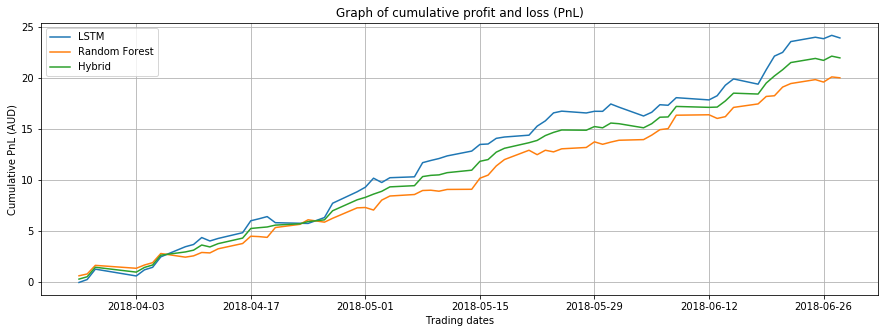

In [330]:
# adjust dataframe and calculate PnL
df_rf_test['predict_hybrid'] = val_hyb

df_temp = df_rf_test.dropna()
df_temp["PnL_hybrid"] = ((df_temp["target"] == df_temp["predict_hybrid"]).astype(int)-0.5)*2*df_temp["ftr_rtn"].abs()

# pnl of the hybrid approach
pnl_hyb = df_temp.groupby(['date'])['PnL_hybrid'].sum()
pnl_hyb = pnl_hyb.iloc[pnl_hyb.index >= '2018-03-27']

# plotting the graph
plt.subplots(figsize=(15, 5))
plt.plot((df_profit.sum(axis=1) - df_loss.sum(axis=1)).cumsum(), label = "LSTM")
plt.plot(pnl.index, pnl.cumsum(), label = "Random Forest")
plt.plot(pnl_hyb.index, pnl_hyb.cumsum(), label = "Hybrid")
plt.xlabel('Trading dates')
plt.ylabel('Cumulative PnL (AUD)')
plt.title('Graph of cumulative profit and loss (PnL)')
plt.legend()
plt.grid()
plt.show()

The PnL graph above shows that the hybrid method performs better than the random forest model, but still worse than the LSTM model. This could be misleading because the number of trades done per day following the hybrid approach is not the same as the other two methods. Let us find out what is the number of trades for the hybrid approach.

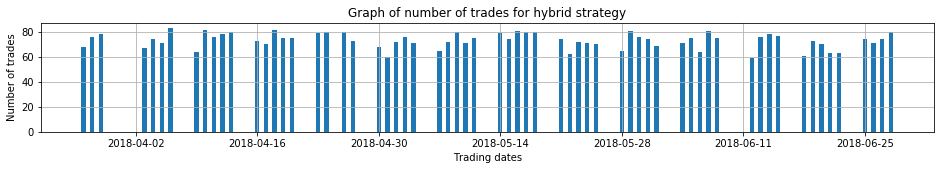

In [332]:
cnt_hybrid = df_rf_test_2.groupby(['date'])['PnL_hybrid'].count()
cnt_rf = df_rf_test.groupby(['date'])['PnL_RF'].count()

plt.subplots(figsize=(16, 2))
plt.bar(cnt_hybrid.index, cnt_hybrid.values, label = "Hybrid", width=0.5, align='center')
plt.xlabel('Trading dates')
plt.ylabel('Number of trades')
plt.title('Graph of number of trades for hybrid strategy')
plt.grid()
plt.show()

As expected, the graph above shows the number of stocks the hybrid strategy trades on is significantly lower than 150. The hybrid method generally does not exceed more than 80 trades per day. Therefore, the more reasonable metric for comparison would be the ROI per day. Let us plot that out using a horizontal bar plot and visualise.

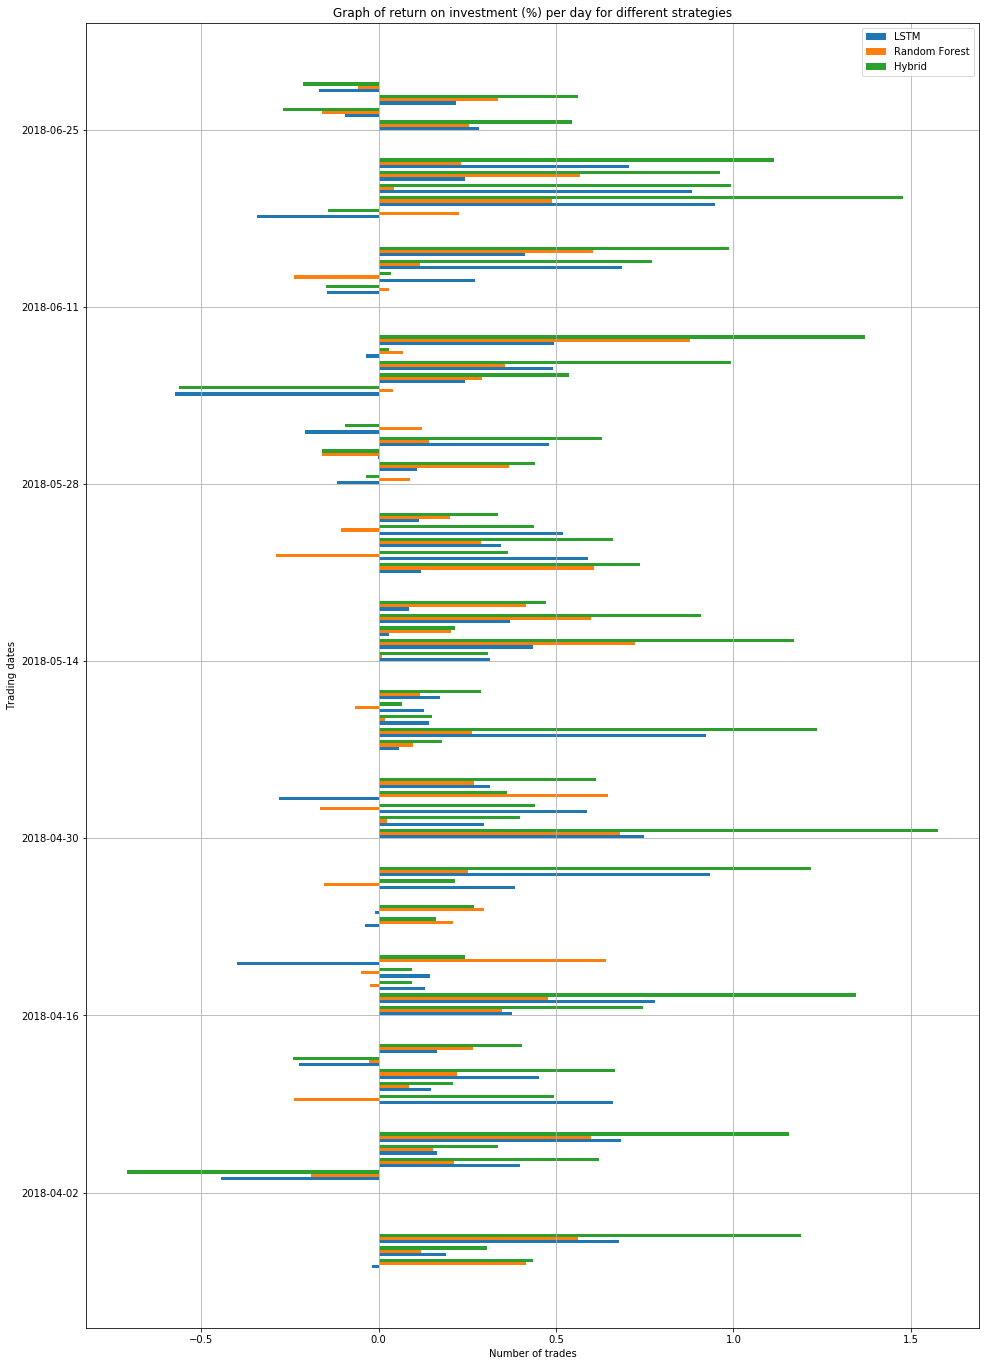

In [335]:
from datetime import timedelta

# pnl of lstm
pnl_lstm = (df_profit.sum(axis=1) - df_loss.sum(axis=1))

# plotting the roi per day
plt.subplots(figsize=(16, 24))
plt.barh((pnl_lstm/150*100).index,(pnl_lstm/150*100).values, label = "LSTM", align='edge', height=0.25)
plt.barh((pnl/cnt_rf*100).index + timedelta(hours=6),(pnl/cnt_rf*100).values, label = "Random Forest", align='edge', height=0.25)
plt.barh((pnl2/cnt_hybrid*100).index + timedelta(hours=12), (pnl2/cnt_hybrid*100).values, label = "Hybrid", align='edge', height=0.25)
plt.xlabel('Number of trades')
plt.ylabel('Trading dates')
plt.title('Graph of return on investment (%) per day for different strategies')
plt.legend()
plt.grid()
plt.show()

The bar plot above shows that the hybrid approach often achieves a higher ROI compared to the other two methods. Many days, the ROI has exceeded 1% and in most cases. 

Now, to cap is off, let us add some statistical significance to all three approaches from the distribution of ROIs.

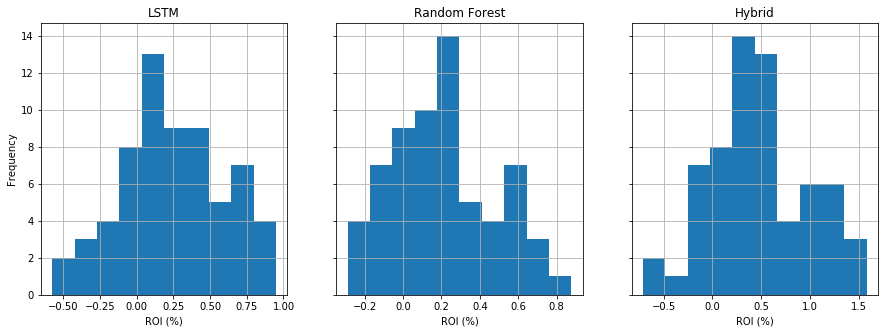

In [336]:
# distribution of ROI
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15, 5), sharey=True)   

ax1.hist((pnl_lstm/150*100).values, bins=10)
ax1.set_title("LSTM")
ax1.set_ylabel('Frequency')
ax1.set_xlabel('ROI (%)')
ax1.grid()

ax2.hist((pnl/cnt_rf*100).values, bins=10)
ax2.set_title("Random Forest")
ax2.set_xlabel('ROI (%)')
ax2.grid()

ax3.hist((pnl2/cnt_hybrid*100).values, bins=10)
ax3.set_title("Hybrid")
ax3.set_xlabel('ROI (%)')
ax3.grid()

The above histograms show that the random forest ROI is positively skewed, which means that most of the ROI values are towards the left hand side tail. This is in line with the performance of cumulative PnL exhibited by the random forest. The hybrid and LSTM models are closer to normal distribution. The only diffence is that the mode of the hybrid is higher (closer to 0.5%) and the right tail extends all the way to 1.5%.

In [227]:
from scipy import stats

# calculating the confidence
conf_lstm = stats.percentileofscore((pnl_lstm/150*100).values, 2) - stats.percentileofscore((pnl_lstm/150*100).values, 0)
conf_rf = stats.percentileofscore((pnl/cnt_rf*100).values, 2) - stats.percentileofscore((pnl/cnt_rf*100).values, 0)
conf_hybrid = stats.percentileofscore((pnl2/cnt_hybrid*100).values, 2) - stats.percentileofscore((pnl2/cnt_hybrid*100).values, 0)

print('Confidence of employed approaches in making positive ROI based on test set:')
print('LSTM: {}%'.format(conf_lstm))
print('Random Forest: {}%'.format(conf_rf))
print('Hybrid: {}%'.format(conf_hybrid))

Confidence of employed approaches in making positive ROI based on test set:
LSTM: 75.0%
Random Forest: 71.875%
Hybrid: 81.25%


Finally, based on all three models and the 64 days of testing, I can with 81% confidence say that the hybrid approach will provide a positive ROI per day, whereas the confidence for LSTM and random forest are 75% and 71% respectively. Based on this statistics, the hybrid approach is the best trading strategy utilising the best of both LSTM and random forest.

## Conclusion

A historical data of all companies in the Australian Securities Exchange (ASX) was given for the task of predicting the next day movement of the securities and subsequently coming up with a trading strategy.

The data was first extracted, analysed, cleaned and features were engineered. Following that, a long short-term memory network and random forest models were built for securities with good predictability. With these two models, a hybrid trading strategy was also proposed.

The results shows that the hybrid approach built based of the two models outperforms both the models in terms of accuracy, precision as well as daily return on investment. It promises a positive investment return with 81% confidence based on testing data.

## Future improvements

Based on this attempt, there are several improvements that can be done to further improve the prediction or trading performance. They are:
- *More refined categorisation*. The label for the currency movemement can be separated into three categories. For example, in the current version, the ones with future return of 0.00, are categorised as 0 which is a downward movement. Perhaps they can be classified into -1, 0, and 1 and build a trading strategy based on these categories.
- *Attempt to tackle hypothesis 2*. The second hypothesis is that the composite indexes are dependent on its constituent securities. Therefore, these securities can be used to predict the movement of composite indexes.
- *Using probabilities from LSTM model*. The softmax activation function from the LSTM model built actually ouputs a probability of the categories. Further investigation is required to include the probailities into the trading strategy.
- *Using convolutional neural network (CNN)*. Research [6-7] and [4], respectively, show that using CNN and a hybrid method of CNN-LSTM can improve the prediction accuracy. This could be an interesting improvement.
- *Hyperparameter search*. With more computing power available, a hyperparameter search can be deployed to find the best parameters for the LSTM and random forest models.
- *News data*. Other types of data, such as news related to the securities, can be added as one of the features, as shown by studies [2, 8]. For example, [2] shows that adding the news information (e.g., sentiment) could boost the prediction accuracy by 10% (~58% to ~70%). 


## References

[1] Borovkova S, Tsiamas I. An ensemble of LSTM neural networks for high-frequency stock market classification. Journal of Forecasting. 2019;1–20. https://doi.org/10.1002/for.2585

[2] Zhai Y, Hsu A, Halgamuge SK. Combining News and Technical Indicators in Daily Stock Price Trends Prediction. Lecture Notes in Computer Science. 2007; https://link.springer.com/chapter/10.1007/978-3-540-72395-0_132

[3] Hegazy O, Soliman OS, Salam MA. A Machine Learning Model for Stock Market Prediction. International Journal of Computer Science and Telecommunications. 2013; 17-23. https://www.ijcst.org/Volume4/Issue12/p4_4_12.pdf

[4] Vargas MR, dos-Anjos CEM, Bichara GLG, Evsukoff AG. Deep Learning for Stock Market Prediction Using Technical Indicators and Financial News Articles. 2018; https://doi.org/10.1109/IJCNN.2018.8489208

[5] Padial DL. Technical Analysis Library in Python. 2019; https://github.com/bukosabino/ta

[6] Selvin S, Vinayakumar R, Gopalakrishnan E.A, Menon VK, Soman K.P. Stock price prediction using LSTM, RNN and CNN-sliding window model. 2017 International Conference on Advances in Computing, Communications and Informatics (ICACCI). 2017; https://doi.org/10.1109/ICACCI.2017.8126078

[7] Chen S, He H. Stock Prediction Using Convolutional Neural Network. IOP Conference Series: Materials Science and Engineering. 2018; https://doi.org/10.1088/1757-899X/435/1/012026

[8] Weng B, Lu L, Wang X, Megahed FM, Martinez W. Predicting Short-Term Stock Prices Using Ensemble Methods and Online Data Sources. Expert Systems with Applications. 2018; https://doi.org/10.1016/j.eswa.2018.06.016